In [1]:
# -*- coding: utf-8 -*-
"""
File created by Tyler McCandless for the NASA-AIST Wildfire Project.

"""
# Imports Required
# Pandas is used for data manipulation, h5py for data (conda install h5py)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.linear_model import LinearRegression
import datetime
import h5py
import numpy.ma as ma
import netCDF4
from netCDF4 import Dataset
import pickle

In [2]:
# Load in HDF5 data
modis_nc = netCDF4.Dataset('/Volumes/d1/mccandle/NASA-AIST/Data/modis/modis-fmc-20160612.nc_terra')
#LAT_CO[:]  = modisCO.variables['XLAT_M'][:]
#LONG_CO[:]  = modisCO.variables['XLONG_M'][:]

geo_nc = netCDF4.Dataset('/Volumes/d1/mccandle/NASA-AIST/Data/geo_em.d01-rec.nc')
#LAT_USA[:]  = modisUSA.variables['XLAT_M'][:]
#LONG_USA[:]  = modisUSA.variables['XLONG_M'][:]

In [3]:
import netCDF4
import pandas as pd
import os
import numpy as np

"""
Script provides functions to get all of the needed prediction features for prediction
"""

modis_features=["ndvi","ndwi","gvmi","pmi","vari","one_km_Surface_Reflectance_Band_1",
                "one_km_Surface_Reflectance_Band_2","one_km_Surface_Reflectance_Band_3",
                "one_km_Surface_Reflectance_Band_4","one_km_Surface_Reflectance_Band_5",
                "one_km_Surface_Reflectance_Band_6","one_km_Surface_Reflectance_Band_7",
                "age_day","LST","lat","lon"]
terra_hour = 17
aqua_hour = 20
hydro_hour_intval = 3
hydro_times_day = (24//hydro_hour_intval)
terra_t = terra_hour//hydro_hour_intval
aqua_t = aqua_hour//hydro_hour_intval

npy_file_path = "/Volumes/d1/mccandle/NASA-AIST/Data"

def interp_wrf_data(data, wrfshape, near_m):
    data = data.reshape(wrfshape[0])
    print("\tInterpolating wrfdata to modis grid using nearest neighbor",flush=True)
    #NN Interpolation using list of locations indexing
    grid_z = data[near_m]
    #Get rid of last dimension
    grid_z = np.squeeze(grid_z)
    return grid_z

def get_x_df(yyyymmdd,modisfile,is_aqua,geoemfile,wrfaccetfile,wrfsoilsatfile,us,gen_plots=False):
    """
    Builds an Pandas DataFrame containing all features needed for prediction
    from a modis file and geo_dm file.
    """
    print("Extracting the MODIS data",flush=True)
    modisnc = netCDF4.Dataset(modisfile)
    modis_grid_shape = modisnc.variables['lat'][:].shape
    feature_map = {}
    for i, feature in enumerate(modis_features):
        feature_datum = modisnc.variables[feature][:]
        assert feature_datum.shape == modis_grid_shape
        feature_datum = feature_datum.flatten()
        feature_map[feature] = feature_datum

    modisnc.close()

    df = pd.DataFrame.from_dict(feature_map)

    print("Extracting the Elev, Slope, Land Use data",flush=True)
    geoemnc = netCDF4.Dataset(geoemfile)
    elev = geoemnc.variables['HGT_M'][0,:,:]
    assert elev.shape == modis_grid_shape
    slopecat = geoemnc.variables['SLOPECAT'][0,:,:]
    assert slopecat.shape == modis_grid_shape
    lu_index = geoemnc.variables['LU_INDEX'][0,:,:]
    assert lu_index.shape == modis_grid_shape
    landmask = geoemnc.variables['LANDMASK'][0,:,:]
    assert landmask.shape == modis_grid_shape
    geoemnc.close()

    el = elev.reshape(3179,5399)
    el = np.where(el==-9999.0, 0, el) 
    slope_x = np.zeros((3179,5399))
    slope_y = np.zeros((3179,5399))

    for i in range(1,3178):
        for j in range(1,5398):
            slope_x[i,j] = el[i+1,j] - el[i-1,j]        
            slope_y[i,j] = el[i,j+1] - el[i,j-1]

    df['slope_x'] = slope_x.flatten()
    df['slope_y'] = slope_y.flatten()  
    df['HDT_M'] = elev.flatten()
    df['SLOPECAT'] = slopecat.flatten()
    df['LU_INDEX'] = lu_index.flatten()
    df['LANDMASK'] = landmask.flatten()

    dd = int(yyyymmdd[6:8])
    
    df['north_west'] = 0
    df['south_west'] = 0
    df['east'] = 0
    df.loc[df['lon'] >= -100.,'east'] = 1
    df.loc[(df['lon'] < -100.) & (df['lat'] > 42.),'north_west'] = 1
    df.loc[(df['lon'] < -100.) & (df['lat'] <= 42.),'south_west'] = 1

    nn_file = os.path.join(npy_file_path,"modis_wrf_nn_%s.npy" % ("us" if us else "co"))
    print("Extracting modis to wrf nearest neighbor index matrix: %s"%nn_file,flush=True)
    if os.path.exists(nn_file):
        near_m = np.load(nn_file)
    else:
        raise "NN file %s does not exist"%nn_file

    assert near_m.shape[0] == modis_grid_shape[0]*modis_grid_shape[1]

    sat_hour_offset = aqua_t if is_aqua else terra_t
    print("Opening WRF Hydro file: %s" % wrfaccetfile,flush=True)
    wrfnc = netCDF4.Dataset(wrfaccetfile)
    accet_var = wrfnc.variables["ACCET"]
    accet_data =  accet_var[(dd-1)*hydro_times_day+sat_hour_offset,:,:]
    if type(accet_var) is not np.ma.core.MaskedArray:
        accet_data = np.ma.core.MaskedArray(accet_data, np.zeros(accet_data.shape, dtype = bool))
    assert len(accet_data.shape) == 2
    ys = wrfnc.variables["y"][:]
    xs = wrfnc.variables["x"][:]
    wrfcoords = np.transpose([np.tile(xs, len(ys)), np.repeat(ys, len(xs))])
    wrfnc.close()

    print("Opening WRF Hydro file: %s" % wrfsoilsatfile,flush=True)
    wrfnc = netCDF4.Dataset(wrfsoilsatfile)
    soilsat_var = wrfnc.variables["SOILSAT_ALL"]
    soilsat_data = soilsat_var[(dd-1)*hydro_times_day+sat_hour_offset,:,:]
    if type(soilsat_var) is not np.ma.core.MaskedArray:
        soilsat_data = np.ma.core.MaskedArray(soilsat_data, np.zeros(soilsat_data.shape, dtype = bool))
    assert len(soilsat_data.shape) == 2
    wrfnc.close()

    print("Interpolating WRF ACCET data",flush=True)
    grid_z_accet = interp_wrf_data(accet_data, wrfcoords.shape, near_m)
    assert len(grid_z_accet) == len(near_m)
    df['accet'] = grid_z_accet

    print("Interpolating WRF SOILSAT_ALL data",flush=True)
    grid_z_soilsat = interp_wrf_data(soilsat_data, wrfcoords.shape, near_m)
    df['soilsat_all'] = grid_z_soilsat
    assert len(grid_z_soilsat) == len(near_m)
    
    if gen_plots:
        import matplotlib
        import matplotlib.pyplot as plt
        matplotlib.use('agg')
        plt.matshow(grid_z_accet.reshape(modis_grid_shape),origin='lower')
        plt.colorbar()
        plt.savefig("grid_z_accet_%s.png"%yyyymmdd)
        plt.matshow(grid_z_soilsat.reshape(modis_grid_shape),origin='lower')
        plt.colorbar()
        plt.savefig("grid_z_soilsat_%s.png"%yyyymmdd)
    
    return df


Extracting the MODIS data
Extracting the Elev, Slope, Land Use data
Extracting modis to wrf nearest neighbor index matrix: /Volumes/d1/mccandle/NASA-AIST/Data/modis_wrf_nn_us.npy
Opening WRF Hydro file: /Volumes/d1/mccandle/NASA-AIST/Data/WRF-Hydro/201606_ACCET.nc4
Opening WRF Hydro file: /Volumes/d1/mccandle/NASA-AIST/Data/WRF-Hydro/201606_SOILSAT.nc4
Interpolating WRF ACCET data
	Interpolating wrfdata to modis grid using nearest neighbor
Interpolating WRF SOILSAT_ALL data
	Interpolating wrfdata to modis grid using nearest neighbor


/Users/mccandle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/mccandle/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/mccandle/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/mccandle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/mccandle/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/mccandle/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", 

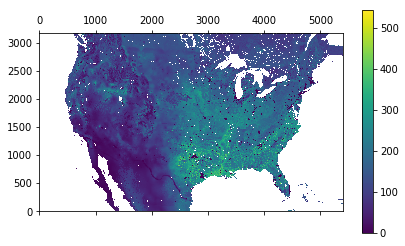

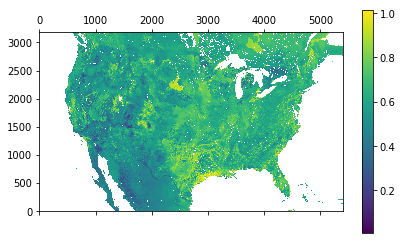

In [4]:
# SECOND PLACE TO UPDATE THE DATE IN EACH OF THE NEXT 5 LINES ##
yyyymmdd = '20160612'
modisfile = '/Volumes/d1/mccandle/NASA-AIST/Data/modis/modis-fmc-20160612.nc_terra'
geoemfile = '/Volumes/d1/mccandle/NASA-AIST/Data/geo_em.d01-rec.nc'
wrfaccetfile = '/Volumes/d1/mccandle/NASA-AIST/Data/WRF-Hydro/201606_ACCET.nc4'
wrfsoilsatfile = '/Volumes/d1/mccandle/NASA-AIST/Data/WRF-Hydro/201606_SOILSAT.nc4'  
us = 'us'
test_df = get_x_df('20160612',modisfile,False,geoemfile,wrfaccetfile,wrfsoilsatfile,us,gen_plots=True)

# test_df = get_x_df('/Volumes/d1/mccandle/NASA-AIST/Data/modis/modis-fmc-20160812.nc_aqua',
#                   '/Volumes/d1/mccandle/NASA-AIST/Data/geo_em.d01-rec.nc')


In [5]:
######### Load the Random Forest Models ##############
import pickle
# Instantiate the Random Forest Model for Aqua
RF_Terra_CONUS_DFMC = open("RF_Terra_CONUS_DFMC.pkl","rb")
rfT = pickle.load(RF_Terra_CONUS_DFMC)

In [6]:
print(test_df.columns)

Index(['ndvi', 'ndwi', 'gvmi', 'pmi', 'vari',
       'one_km_Surface_Reflectance_Band_1',
       'one_km_Surface_Reflectance_Band_2',
       'one_km_Surface_Reflectance_Band_3',
       'one_km_Surface_Reflectance_Band_4',
       'one_km_Surface_Reflectance_Band_5',
       'one_km_Surface_Reflectance_Band_6',
       'one_km_Surface_Reflectance_Band_7', 'age_day', 'LST', 'lat', 'lon',
       'slope_x', 'slope_y', 'HDT_M', 'SLOPECAT', 'LU_INDEX', 'LANDMASK',
       'north_west', 'south_west', 'east', 'accet', 'soilsat_all'],
      dtype='object')


In [7]:
storeA = pd.DataFrame()
storeA['b1'] = test_df['one_km_Surface_Reflectance_Band_1']
storeA['b2'] = test_df['one_km_Surface_Reflectance_Band_2']
storeA['b3'] = test_df['one_km_Surface_Reflectance_Band_3']
storeA['b4'] = test_df['one_km_Surface_Reflectance_Band_4']
storeA['b5'] = test_df['one_km_Surface_Reflectance_Band_5']
storeA['b6'] = test_df['one_km_Surface_Reflectance_Band_6']
storeA['b7'] = test_df['one_km_Surface_Reflectance_Band_7']
storeA['lat'] = test_df['lat']
storeA['lon'] = test_df['lon']
storeA['elevation'] = test_df['HDT_M']
storeA['land_use_cat'] = test_df['LU_INDEX']
storeA['LST'] = test_df['LST']
storeA['landmask'] = test_df['LANDMASK']
storeA['x_slope'] = test_df['slope_x']
storeA['y_slope'] = test_df['slope_y']

storeA['north_west'] = test_df['north_west']
storeA['south_west'] = test_df['south_west']
storeA['east'] = test_df['east']
storeA['soilsat_all'] = test_df['soilsat_all']
storeA['accet'] = test_df['accet']

In [8]:
test_featuresA = storeA[['b1','b2','b3','b4','b5','b6','b7','elevation','soilsat_all','accet', 'x_slope','y_slope','LST','land_use_cat','north_west','south_west','east']]

In [9]:
#storeA[storeA==np.inf]=np.nan
#storeA.fillna(storeA.mean(), inplace = True)
store = storeA.replace(np.inf, np.NaN)
store = storeA.replace(-9999.0,np.NaN).fillna(storeA.mean())
print(np.shape(store))
test_features = store[['b1','b2','b3','b4','b5','b6','b7','elevation','soilsat_all','accet',
                       'x_slope','y_slope','LST','land_use_cat','north_west','south_west','east']]
dfmc = rfT.predict(test_features)
lm = np.array(storeA['landmask'])
DFMC = dfmc*0.01*lm
store['DFMC'] = DFMC

(17163421, 20)


In [10]:
# Remove the regions to make a prediction for the LFMC
######### Load the Random Forest Model for LFMC ##############
RF_Terra_CONUS_LFMC = open("RF_Terra_CONUS_LFMC.pkl","rb")
rfLFMC = pickle.load(RF_Terra_CONUS_LFMC)
test_features = store[['b1','b2','b3','b4','b5','b6','b7','elevation','soilsat_all','accet',
                       'x_slope','y_slope','LST','land_use_cat']]
lfmc = rfLFMC.predict(test_features)
LFMC = lfmc*0.01*lm
store['LFMC'] = LFMC

In [11]:
# Save the files 
#ml.close()
ml = netCDF4.Dataset('/Volumes/d1/mccandle/NASA-AIST/Data/geo/geo_em.d01-rec_2016-06-12_terra.nc','a')
ml.time = "2016-06-12_10:30:00" #this will need to be updated...

# Define additional global attributes
ml.DX = float(1000)
ml.DY = float(1000)
ml.TRUELAT1 = float(38.5)
ml.TRUELAT2 = float(38.5)
ml.STAND_LON = float(-97.5)

FMCG2D = ml.createVariable('FMCG2D',np.float32,('Time','south_north','west_east'))
FMCG2D.FieldType = 104
FMCG2D.MemoryOrder = "XY "
FMCG2D.units = "decimals"
FMCG2D.description = "Dead Fuel Moisture Content"
FMCG2D.stagger = "M"
FMCG2D.sr_x = 1
FMCG2D.sr_y = 1
FMCG2D[0,:,:] = DFMC

FMCGLH2D = ml.createVariable('FMCGLH2D',np.float32,('Time','south_north','west_east'))
FMCGLH2D.FieldType = 104
FMCGLH2D.MemoryOrder = "XY "
FMCGLH2D.units = "decimals"
FMCGLH2D.description = "Live Fuel Moisture Content"
FMCGLH2D.stagger = "M"
FMCGLH2D.sr_x = 1
FMCGLH2D.sr_y = 1
FMCGLH2D[0,:,:] = LFMC

ml.close()

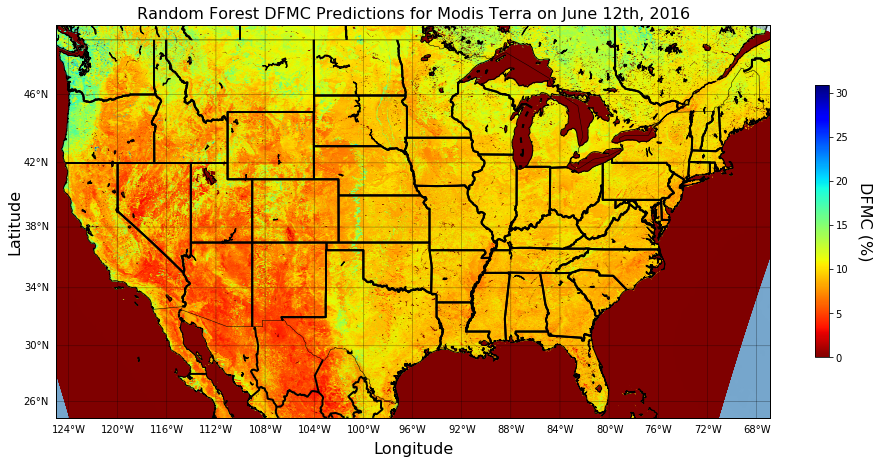

In [12]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pylab

%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 10)

store['PredictionsDFMC'] = DFMC * 100
TL = store[['b1','b2','b3','b4','b5','b6','b7','elevation','soilsat_all','accet', 'x_slope','y_slope','LST','land_use_cat','north_west','south_west','east','lat','lon','PredictionsDFMC']]

#TL = pd.DataFrame(data=test_featuresT,columns=['b1','b2','b3','b4','b5','b6','b7','elevation','slope_cat','land_use_cat',
#                           'LST','soil_layer_0','soil_layer_1','soil_layer_2','soil_layer_3', 'lat','lon',
#                                         'Predictions', 'Errors'])

j = TL.groupby(['lat', 'lon']).mean().reset_index()
lat = np.array(j['lat'])
lon = np.array(j['lon'])
m = Basemap(projection='merc',llcrnrlat=24.80,urcrnrlat=49.8,llcrnrlon=-125,urcrnrlon=-66.87, resolution = 'i')
m.drawcoastlines()
m.drawcountries()
#m.etopo()
m.shadedrelief(scale=2.0)
m.drawstates(color='black',linewidth=2.0)
# draw parallels and meridians.
parallels = np.arange(-90.,91.,4.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5)
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,4.)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.5)
m.drawmapboundary(fill_color='white')
plt.xlabel('Longitude',fontsize=16, labelpad=24)
plt.ylabel('Latitude',fontsize=16, labelpad=34)
plt.title("Random Forest DFMC Predictions for Modis Terra on June 12th, 2016",fontsize=16)
# Define a colormap
jet = plt.cm.get_cmap('jet_r')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
# Use below initially...then set vmin and cmax if comparing tables and want the same range
sc = plt.scatter(x,y, c=j['PredictionsDFMC'], vmin=0, vmax = np.max(j['PredictionsDFMC']), cmap=jet, s=1, edgecolors='none')
#sc = plt.scatter(x,y, c=j['Predictions'], vmin=0, vmax=8, cmap=jet, s=100, edgecolors='none')# And let's include that colorbar
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
cbar.set_label('DFMC (%)', rotation=270,fontsize=16, labelpad=24)
#cbar.set_label(j['fuelMoisture'])
#x1,y1 = m([-105.4894],[39.98443])
#sc = plt.plot(x1,y1,"*",markersize=15, color="red")
plt.show()

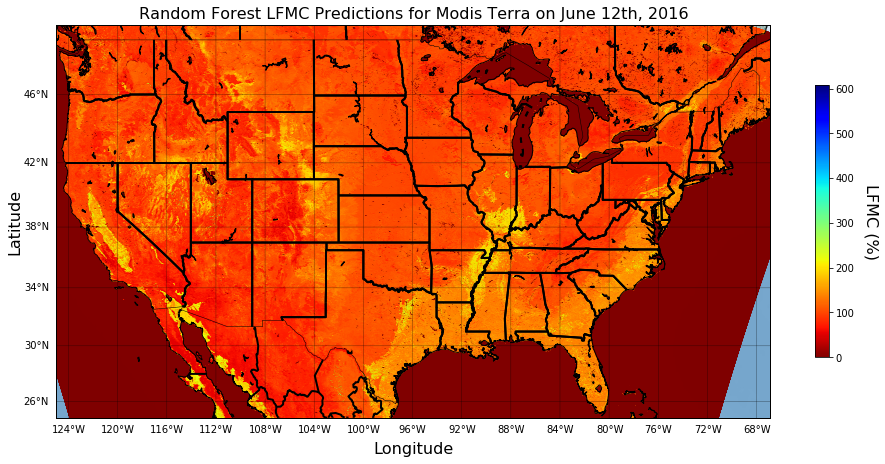

In [13]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pylab

%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 10)

store['PredictionsLFMC'] = LFMC * 100
TL = store[['b1','b2','b3','b4','b5','b6','b7','elevation','soilsat_all','accet', 'x_slope','y_slope','LST','land_use_cat','north_west','south_west','east','lat','lon','PredictionsLFMC']]

#TL = pd.DataFrame(data=test_featuresT,columns=['b1','b2','b3','b4','b5','b6','b7','elevation','slope_cat','land_use_cat',
#                           'LST','soil_layer_0','soil_layer_1','soil_layer_2','soil_layer_3', 'lat','lon',
#                                         'Predictions', 'Errors'])

j = TL.groupby(['lat', 'lon']).mean().reset_index()
lat = np.array(j['lat'])
lon = np.array(j['lon'])
m = Basemap(projection='merc',llcrnrlat=24.80,urcrnrlat=49.8,llcrnrlon=-125,urcrnrlon=-66.87, resolution = 'i')
m.drawcoastlines()
m.drawcountries()
#m.etopo()
m.shadedrelief(scale=2.0)
m.drawstates(color='black',linewidth=2.0)
# draw parallels and meridians.
parallels = np.arange(-90.,91.,4.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5)
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,4.)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.5)
m.drawmapboundary(fill_color='white')
plt.xlabel('Longitude',fontsize=16, labelpad=24)
plt.ylabel('Latitude',fontsize=16, labelpad=34)
plt.title("Random Forest LFMC Predictions for Modis Terra on June 12th, 2016",fontsize=16)
# Define a colormap
jet = plt.cm.get_cmap('jet_r')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
# Use below initially...then set vmin and cmax if comparing tables and want the same range
sc = plt.scatter(x,y, c=j['PredictionsLFMC'], vmin=0, vmax = np.max(j['PredictionsLFMC']), cmap=jet, s=1, edgecolors='none')
#sc = plt.scatter(x,y, c=j['Predictions'], vmin=0, vmax=8, cmap=jet, s=100, edgecolors='none')# And let's include that colorbar
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
cbar.set_label('LFMC (%)', rotation=270,fontsize=16, labelpad=24)
#cbar.set_label(j['fuelMoisture'])
#x1,y1 = m([-105.4894],[39.98443])
#sc = plt.plot(x1,y1,"*",markersize=15, color="red")
plt.show()

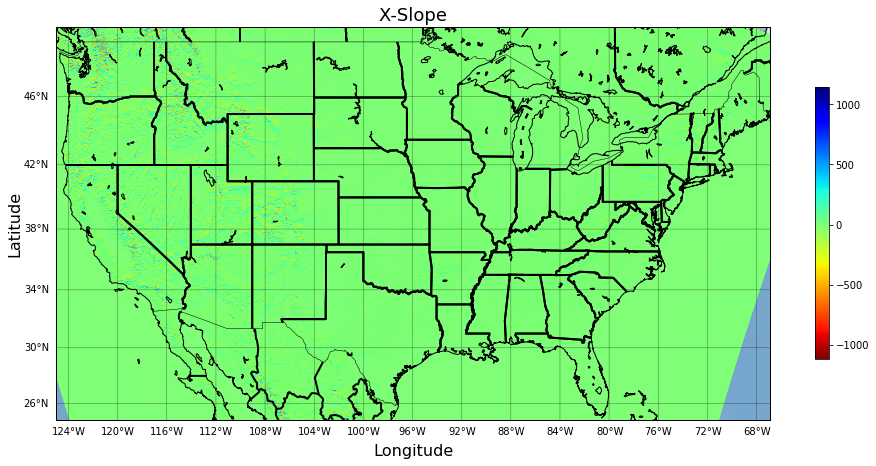

In [45]:
store['lat'] = storeA['lat']
store['lon'] = storeA['lon']

%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 10)

TL = store[['b1','b2','b3','b4','b5','b6','b7','elevation','soilsat_all','accet', 'x_slope','y_slope','LST','land_use_cat','north_west','south_west','east','lat','lon','Predictions']]

j = TL.groupby(['lat', 'lon']).mean().reset_index()
lat = np.array(j['lat'])
lon = np.array(j['lon'])
m = Basemap(projection='merc',llcrnrlat=24.80,urcrnrlat=49.8,llcrnrlon=-125,urcrnrlon=-66.87, resolution = 'i')
m.drawcoastlines()
m.drawcountries()
#m.etopo()
m.shadedrelief(scale=2.0)
m.drawstates(color='black',linewidth=2.0)
# draw parallels and meridians.
parallels = np.arange(-90.,91.,4.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5)
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,4.)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.5)
m.drawmapboundary(fill_color='white')
plt.xlabel('Longitude',fontsize=16, labelpad=24)
plt.ylabel('Latitude',fontsize=16, labelpad=34)
plt.title("X-Slope",fontsize=18)
# Define a colormap
jet = plt.cm.get_cmap('jet_r')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
# Use below initially...then set vmin and cmax if comparing tables and want the same range
sc = plt.scatter(x,y, c=j['x_slope'], vmin=np.min(j['x_slope']), vmax =np.max(j['x_slope']), cmap=jet, s=1, edgecolors='none')
#sc = plt.scatter(x,y, c=j['Predictions'], vmin=0, vmax=8, cmap=jet, s=100, edgecolors='none')# And let's include that colorbar
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
#cbar.set_label(j['fuelMoisture'])
#x1,y1 = m([-105.4894],[39.98443])
#sc = plt.plot(x1,y1,"*",markersize=15, color="red")
plt.show()

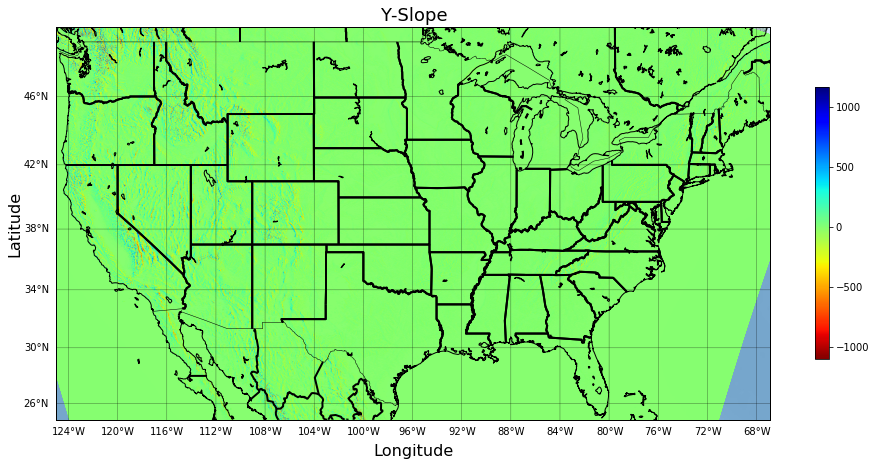

In [46]:
store['lat'] = storeA['lat']
store['lon'] = storeA['lon']

%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 10)

TL = store[['b1','b2','b3','b4','b5','b6','b7','elevation','soilsat_all','accet', 'x_slope','y_slope','LST','land_use_cat','north_west','south_west','east','lat','lon','Predictions']]

j = TL.groupby(['lat', 'lon']).mean().reset_index()
lat = np.array(j['lat'])
lon = np.array(j['lon'])
m = Basemap(projection='merc',llcrnrlat=24.80,urcrnrlat=49.8,llcrnrlon=-125,urcrnrlon=-66.87, resolution = 'i')
m.drawcoastlines()
m.drawcountries()
#m.etopo()
m.shadedrelief(scale=2.0)
m.drawstates(color='black',linewidth=2.0)
# draw parallels and meridians.
parallels = np.arange(-90.,91.,4.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5)
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,4.)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.5)
m.drawmapboundary(fill_color='white')
plt.xlabel('Longitude',fontsize=16, labelpad=24)
plt.ylabel('Latitude',fontsize=16, labelpad=34)
plt.title("Y-Slope",fontsize=18)
# Define a colormap
jet = plt.cm.get_cmap('jet_r')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
# Use below initially...then set vmin and cmax if comparing tables and want the same range
sc = plt.scatter(x,y, c=j['y_slope'], vmin=np.min(j['y_slope']), vmax =np.max(j['y_slope']), cmap=jet, s=1, edgecolors='none')
#sc = plt.scatter(x,y, c=j['Predictions'], vmin=0, vmax=8, cmap=jet, s=100, edgecolors='none')# And let's include that colorbar
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
#cbar.set_label(j['fuelMoisture'])
#x1,y1 = m([-105.4894],[39.98443])
#sc = plt.plot(x1,y1,"*",markersize=15, color="red")
plt.show()

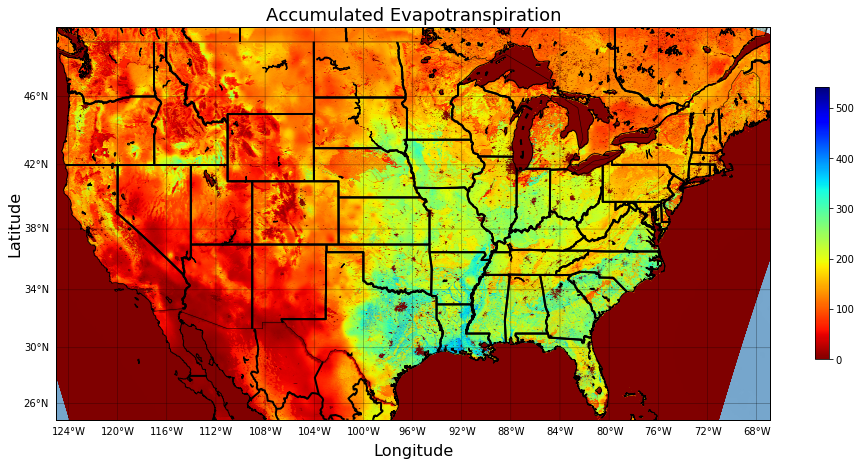

In [19]:
store['lat'] = storeA['lat']
store['lon'] = storeA['lon']

%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 10)

TL = store[['b1','b2','b3','b4','b5','b6','b7','elevation','soilsat_all','accet', 'x_slope','y_slope','LST','land_use_cat','north_west','south_west','east','lat','lon','Predictions']]


j = TL.groupby(['lat', 'lon']).mean().reset_index()
lat = np.array(j['lat'])
lon = np.array(j['lon'])
m = Basemap(projection='merc',llcrnrlat=24.80,urcrnrlat=49.8,llcrnrlon=-125,urcrnrlon=-66.87, resolution = 'i')
m.drawcoastlines()
m.drawcountries()
#m.etopo()
m.shadedrelief(scale=2.0)
m.drawstates(color='black',linewidth=2.0)
# draw parallels and meridians.
parallels = np.arange(-90.,91.,4.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5)
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,4.)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.5)
m.drawmapboundary(fill_color='white')
plt.xlabel('Longitude',fontsize=16, labelpad=24)
plt.ylabel('Latitude',fontsize=16, labelpad=34)
plt.title("Accumulated Evapotranspiration",fontsize=18)
# Define a colormap
jet = plt.cm.get_cmap('jet_r')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
# Use below initially...then set vmin and cmax if comparing tables and want the same range
sc = plt.scatter(x,y, c=j['accet'], vmin=0, vmax =np.max(j['accet']), cmap=jet, s=1, edgecolors='none')
#sc = plt.scatter(x,y, c=j['Predictions'], vmin=0, vmax=8, cmap=jet, s=100, edgecolors='none')# And let's include that colorbar
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
#cbar.set_label(j['fuelMoisture'])
#x1,y1 = m([-105.4894],[39.98443])
#sc = plt.plot(x1,y1,"*",markersize=15, color="red")
plt.show()

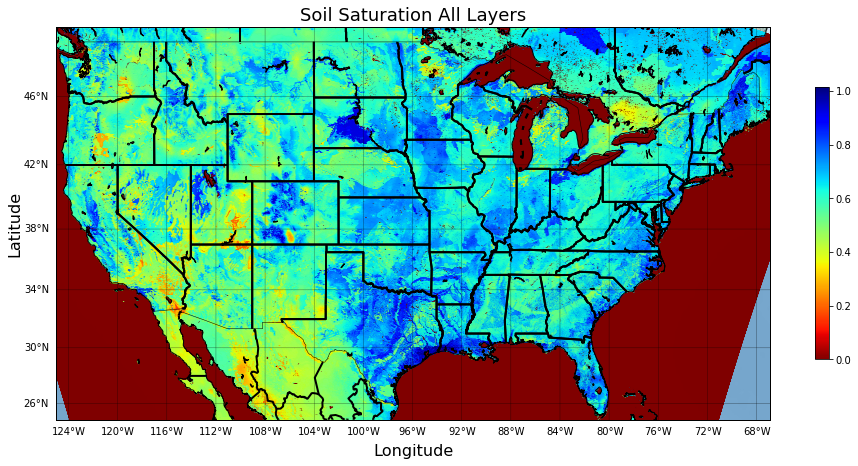

In [20]:
store['lat'] = storeA['lat']
store['lon'] = storeA['lon']

%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 10)

TL = store[['b1','b2','b3','b4','b5','b6','b7','elevation','soilsat_all','accet', 'x_slope','y_slope','LST','land_use_cat','north_west','south_west','east','lat','lon','Predictions']]

j = TL.groupby(['lat', 'lon']).mean().reset_index()
lat = np.array(j['lat'])
lon = np.array(j['lon'])
m = Basemap(projection='merc',llcrnrlat=24.80,urcrnrlat=49.8,llcrnrlon=-125,urcrnrlon=-66.87, resolution = 'i')
m.drawcoastlines()
m.drawcountries()
#m.etopo()
m.shadedrelief(scale=2.0)
m.drawstates(color='black',linewidth=2.0)
# draw parallels and meridians.
parallels = np.arange(-90.,91.,4.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5)
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,4.)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.5)
m.drawmapboundary(fill_color='white')
plt.xlabel('Longitude',fontsize=16, labelpad=24)
plt.ylabel('Latitude',fontsize=16, labelpad=34)
plt.title("Soil Saturation All Layers",fontsize=18)
# Define a colormap
jet = plt.cm.get_cmap('jet_r')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
# Use below initially...then set vmin and cmax if comparing tables and want the same range
sc = plt.scatter(x,y, c=j['soilsat_all'], vmin=0, vmax =np.max(j['soilsat_all']), cmap=jet, s=1, edgecolors='none')
#sc = plt.scatter(x,y, c=j['Predictions'], vmin=0, vmax=8, cmap=jet, s=100, edgecolors='none')# And let's include that colorbar
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
#cbar.set_label(j['fuelMoisture'])
#x1,y1 = m([-105.4894],[39.98443])
#sc = plt.plot(x1,y1,"*",markersize=15, color="red")
plt.show()

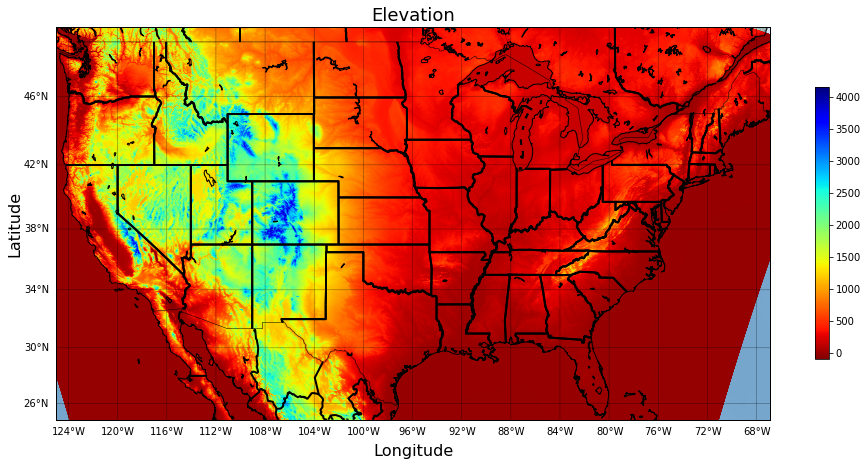

In [58]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pylab
store['lat'] = storeA['lat']
store['lon'] = storeA['lon']

%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 10)

TL = store[['b1','b2','b3','b4','b5','b6','b7','elevation','soilsat_all','accet', 'x_slope','y_slope','LST','land_use_cat','north_west','south_west','east','lat','lon','Predictions']]

j = TL.groupby(['lat', 'lon']).mean().reset_index()
lat = np.array(j['lat'])
lon = np.array(j['lon'])
m = Basemap(projection='merc',llcrnrlat=24.80,urcrnrlat=49.8,llcrnrlon=-125,urcrnrlon=-66.87, resolution = 'i')
m.drawcoastlines()
m.drawcountries()
#m.etopo()
m.shadedrelief(scale=2.0)
m.drawstates(color='black',linewidth=2.0)
# draw parallels and meridians.
parallels = np.arange(-90.,91.,4.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5)
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,4.)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.5)
m.drawmapboundary(fill_color='white')
plt.xlabel('Longitude',fontsize=16, labelpad=24)
plt.ylabel('Latitude',fontsize=16, labelpad=34)
plt.title("Elevation",fontsize=18)
# Define a colormap
jet = plt.cm.get_cmap('jet_r')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
# Use below initially...then set vmin and cmax if comparing tables and want the same range
sc = plt.scatter(x,y, c=j['elevation'], vmin=np.min(j['elevation']), vmax =np.max(j['elevation']), cmap=jet, s=1, edgecolors='none')
#sc = plt.scatter(x,y, c=j['Predictions'], vmin=0, vmax=8, cmap=jet, s=100, edgecolors='none')# And let's include that colorbar
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
#cbar.set_label(j['fuelMoisture'])
#x1,y1 = m([-105.4894],[39.98443])
#sc = plt.plot(x1,y1,"*",markersize=15, color="red")
plt.show()

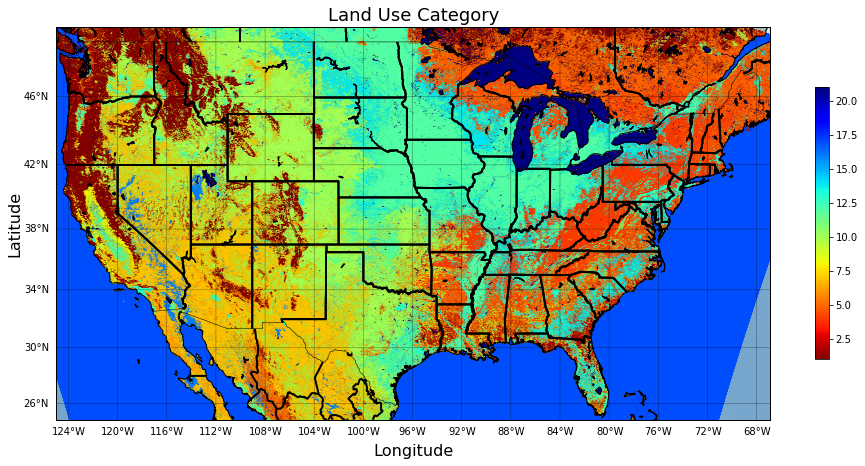

In [59]:
store['lat'] = storeA['lat']
store['lon'] = storeA['lon']

%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 10)

TL = store[['b1','b2','b3','b4','b5','b6','b7','elevation','soilsat_all','accet', 'x_slope','y_slope','LST','land_use_cat','north_west','south_west','east','lat','lon','Predictions']]

j = TL.groupby(['lat', 'lon']).mean().reset_index()
lat = np.array(j['lat'])
lon = np.array(j['lon'])
m = Basemap(projection='merc',llcrnrlat=24.80,urcrnrlat=49.8,llcrnrlon=-125,urcrnrlon=-66.87, resolution = 'i')
m.drawcoastlines()
m.drawcountries()
#m.etopo()
m.shadedrelief(scale=2.0)
m.drawstates(color='black',linewidth=2.0)
# draw parallels and meridians.
parallels = np.arange(-90.,91.,4.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5)
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,4.)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.5)
m.drawmapboundary(fill_color='white')
plt.xlabel('Longitude',fontsize=16, labelpad=24)
plt.ylabel('Latitude',fontsize=16, labelpad=34)
plt.title("Land Use Category",fontsize=18)
# Define a colormap
jet = plt.cm.get_cmap('jet_r')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
# Use below initially...then set vmin and cmax if comparing tables and want the same range
sc = plt.scatter(x,y, c=j['land_use_cat'], vmin=np.min(j['land_use_cat']), vmax =np.max(j['land_use_cat']), cmap=jet, s=1, edgecolors='none')
#sc = plt.scatter(x,y, c=j['Predictions'], vmin=0, vmax=8, cmap=jet, s=100, edgecolors='none')# And let's include that colorbar
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
#cbar.set_label(j['fuelMoisture'])
#x1,y1 = m([-105.4894],[39.98443])
#sc = plt.plot(x1,y1,"*",markersize=15, color="red")
plt.show()

In [41]:
######### Load the Random Forest Models ##############
import pickle
# Instantiate the Random Forest Model for Aqua
rfA_CS_pkl_2016 = open("RF_Aqua_pkl_2016_CO.pkl","rb")
rfA = pickle.load(rfA_CS_pkl_2016)
#
store = storeA.replace(np.inf, np.NaN)
store = storeA.replace(-9999.0,np.NaN).fillna(storeA.mean())
print(np.shape(store))
test_features = store[['b1','b2','b3','b4','b5','b6','b7','elevation','land_use_cat', 'x_slope','y_slope','LST']]
predictionsA1 = rfA.predict(test_features)
lm = np.array(storeA['landmask'])
predictionsA = predictionsA1*0.01*lm
store['Predictions'] = predictionsA



(17163421, 15)


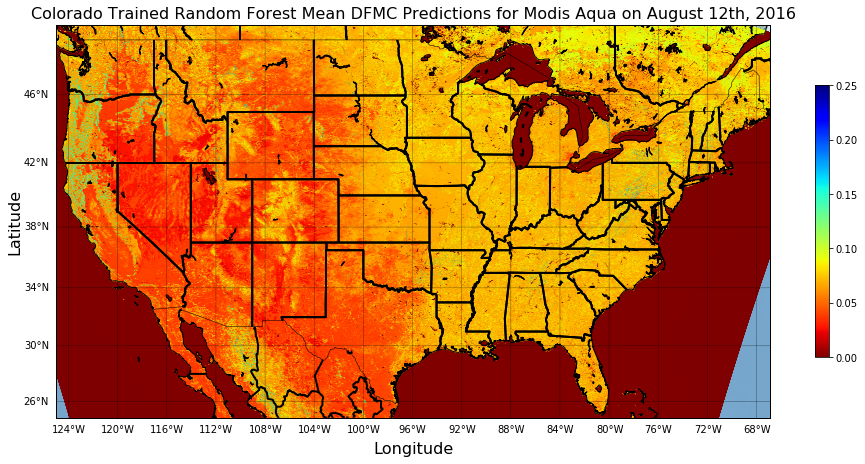

In [42]:
import os
import conda


conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pylab

%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 10)

TL = store[['b1','b2','b3','b4','b5','b6','b7','elevation','land_use_cat', 'x_slope','y_slope','LST','lat','lon','Predictions']]


#TL = pd.DataFrame(data=test_featuresT,columns=['b1','b2','b3','b4','b5','b6','b7','elevation','slope_cat','land_use_cat',
#                           'LST','soil_layer_0','soil_layer_1','soil_layer_2','soil_layer_3', 'lat','lon',
#                                         'Predictions', 'Errors'])

j = TL.groupby(['lat', 'lon']).mean().reset_index()
lat = np.array(j['lat'])
lon = np.array(j['lon'])
m = Basemap(projection='merc',llcrnrlat=24.80,urcrnrlat=49.8,llcrnrlon=-125,urcrnrlon=-66.87, resolution = 'i')
m.drawcoastlines()
m.drawcountries()
#m.etopo()
m.shadedrelief(scale=2.0)
m.drawstates(color='black',linewidth=2.0)
# draw parallels and meridians.
parallels = np.arange(-90.,91.,4.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5)
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,4.)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.5)
m.drawmapboundary(fill_color='white')
plt.xlabel('Longitude',fontsize=16, labelpad=24)
plt.ylabel('Latitude',fontsize=16, labelpad=34)
plt.title("Colorado Trained Random Forest Mean DFMC Predictions for Modis Aqua on August 12th, 2016",fontsize=16)
# Define a colormap
jet = plt.cm.get_cmap('jet_r')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
# Use below initially...then set vmin and cmax if comparing tables and want the same range
sc = plt.scatter(x,y, c=j['Predictions'], vmin=0, vmax =0.25, cmap=jet, s=1, edgecolors='none')
#sc = plt.scatter(x,y, c=j['Predictions'], vmin=0, vmax=8, cmap=jet, s=100, edgecolors='none')# And let's include that colorbar
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
#cbar.set_label(j['fuelMoisture'])
#x1,y1 = m([-105.4894],[39.98443])
#sc = plt.plot(x1,y1,"*",markersize=15, color="red")
plt.show()

In [ ]:
#ml.close()
ml = netCDF4.Dataset('/Volumes/d1/mccandle/NASA-AIST/Data/geo/geo_em.d01-rec_2016-09-08_aqua.nc','a')
ml.time = "2016-09-08_13:30:00" #this will need to be updated...

# Define additional global attributes
ml.DX = float(1000)
ml.DY = float(1000)
ml.TRUELAT1 = float(38.5)
ml.TRUELAT2 = float(38.5)
ml.STAND_LON = float(-97.5)

FMCG2D = ml.createVariable('FMCG2D',np.float32,('Time','south_north','west_east'))
FMCG2D.FieldType = 104
FMCG2D.MemoryOrder = "XY "
FMCG2D.units = "decimals"
FMCG2D.description = "Dead Fuel Moisture Content"
FMCG2D.stagger = "M"
FMCG2D.sr_x = 1
FMCG2D.sr_y = 1
FMCG2D[0,:,:] = predictionsA

FMCGLH2D = ml.createVariable('FMCGLH2D',np.float32,('Time','south_north','west_east'))
FMCGLH2D.FieldType = 104
FMCGLH2D.MemoryOrder = "XY "
FMCGLH2D.units = "decimals"
FMCGLH2D.description = "Live Fuel Moisture Content"
FMCGLH2D.stagger = "M"
FMCGLH2D.sr_x = 1
FMCGLH2D.sr_y = 1
FMCGLH2D[0,:,:] = 1.2

ml.close()

NameError: name 'modisUSA' is not defined

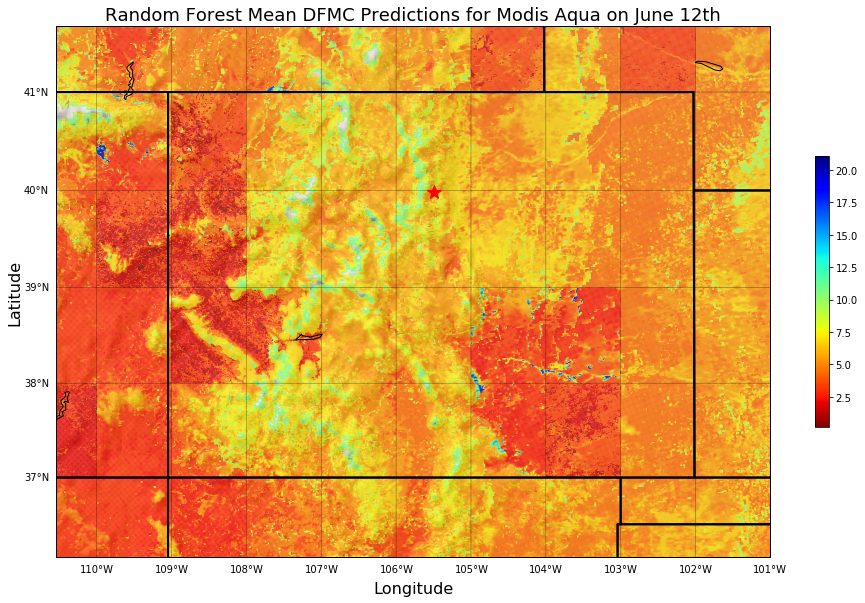

In [13]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pylab

%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 10)

TL = store[['b1','b2','b3','b4','b5','b6','b7','elevation','slope_cat','land_use_cat','LST','lat','lon','Predictions']]


#TL = pd.DataFrame(data=test_featuresT,columns=['b1','b2','b3','b4','b5','b6','b7','elevation','slope_cat','land_use_cat',
#                           'LST','soil_layer_0','soil_layer_1','soil_layer_2','soil_layer_3', 'lat','lon',
#                                         'Predictions', 'Errors'])

j = TL.groupby(['lat', 'lon']).mean().reset_index()
lat = np.array(j['lat'])
lon = np.array(j['lon'])
m = Basemap(projection='merc',llcrnrlat=36.15,urcrnrlat=41.66,llcrnrlon=-110.54,urcrnrlon=-101.00, resolution = 'i')
m.drawcoastlines()
m.drawcountries()
#m.etopo()
m.shadedrelief(scale=2.0)
m.drawstates(color='black',linewidth=2.0)
# draw parallels and meridians.
parallels = np.arange(-90.,91.,1.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5)
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,1.)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.5)
m.drawmapboundary(fill_color='white')
plt.xlabel('Longitude',fontsize=16, labelpad=24)
plt.ylabel('Latitude',fontsize=16, labelpad=34)
plt.title("Random Forest Mean DFMC Predictions for Modis Aqua on June 12th",fontsize=18)
# Define a colormap
jet = plt.cm.get_cmap('jet_r')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
# Use below initially...then set vmin and cmax if comparing tables and want the same range
sc = plt.scatter(x,y, c=j['Predictions'], vmin=np.min(j['Predictions']), vmax =np.max(j['Predictions']), cmap=jet, s=1, edgecolors='none')
#sc = plt.scatter(x,y, c=j['Predictions'], vmin=0, vmax=8, cmap=jet, s=100, edgecolors='none')# And let's include that colorbar
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
#cbar.set_label(j['fuelMoisture'])
x1,y1 = m([-105.4894],[39.98443])
sc = plt.plot(x1,y1,"*",markersize=15, color="red")
plt.show()

In [ ]:
#ml.close()
ml = netCDF4.Dataset('/Volumes/d1/mccandle/NASA-AIST/Data/geo-conus-1km_2019-07-09.nc','a')
FMC = ml.createVariable('FMC',np.float32,('south_north','west_east'))
FMC.FieldType = 104
FMC.MemoryOrder = "XY "
FMC.units = "decimals"
FMC.description = "Dead Fuel Moisture Content"
FMC.stagger = "M"
FMC.sr_x = 1
FMC.sr_y = 1
FMC[:] = DFMC
ml.close()

In [73]:
######### Load the Random Forest Models ##############
import pickle
# Instantiate the Random Forest Model for Aqua
rfA_CS_pkl = open("RF_Aqua_CS.pkl","rb")
rfA = pickle.load(rfA_CS_pkl)

In [74]:
#train_setA = storeA[((storeA['raws_date'] > 20160716.0) | (storeA['raws_date'] < 20160709.0))]
#test_setA = storeA[((storeA['raws_date'] < 20160716.0) & (storeA['raws_date'] > 20160709.0))]

test_featuresA = storeA[['b1','b2','b3','b4','b5','b6','b7','elevation','slope_cat','land_use_cat','LST']]
test_labelsA = storeA['dFMC']



print("Stats about the training and testing data for Aqua:")
print("The DFMC mean for the test dataset: ", np.mean(test_labelsA))
print("The DFMC std for the test dataset: ", np.std(test_labelsA))
print("The DFMC max for the test dataset: ", np.max(test_labelsA))
print("The DFMC min for the test dataset: ", np.min(test_labelsA))
print("Size of test dataset",np.shape(test_labelsA))

Stats about the training and testing data for Aqua:
The DFMC mean for the test dataset:  -1674.393376993542
The DFMC std for the test dataset:  3738.6036861697926
The DFMC max for the test dataset:  7.999999999999908
The DFMC min for the test dataset:  -9999.0
Size of test dataset (595576,)


In [ ]:
#storeA[storeA==np.inf]=np.nan
#storeA.fillna(storeA.mean(), inplace = True)
store = storeA.replace(np.inf, np.NaN)
store = storeA.replace(-9999.0,np.NaN).dropna(axis=0,how='any')
print(np.shape(store))
test_features = store[['b1','b2','b3','b4','b5','b6','b7','elevation','slope_cat','land_use_cat','LST']]
predictionsA = rfA.predict(test_features)
store['Predictions'] = predictionsA

In [75]:
print('n_estimators = 500, min_samples_split = 100, min_samples_leaf = 100')
# Use the forest's predict method on the test data for Aqua
predictionsA = rfA.predict(test_featuresA)
######### Compute Errors on Test Data #############
# Calculate the absolute errors
errorsA = abs(predictionsA - test_labelsA)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for the Random Forest on Aqua for test:', round(np.mean(errorsA), 2))
print(np.mean(predictionsA))
print(np.min(predictionsA))
print(np.max(predictionsA))

n_estimators = 500, min_samples_split = 100, min_samples_leaf = 100
Mean Absolute Error for the Random Forest on Aqua for test: 1680.59
5.003848673771231
0.053279281498577
22.308263915262867


In [76]:
storeA['Errors'] = errorsA
predictionsA = rfA.predict(test_featuresA)
storeA['Predictions'] = predictionsA


In [77]:
xlat_m  = modisnc.variables['XLAT_M']
xlong_m  = modisnc.variables['XLONG_M']
print(np.shape(xlat_m))

(683, 872)


In [78]:
xlong_m0  = modisnc.variables['XLONG_M'][:][0]
xlong_m1  = modisnc.variables['XLONG_M'][0][:]
xlong_m2  = modisnc.variables['XLONG_M'][:]
print(np.shape(xlong_m0))
print(np.shape(xlong_m1))
print(np.shape(xlong_m2))
xlat_m0  = modisnc.variables['XLAT_M'][:][0]
xlat_m1  = modisnc.variables['XLAT_M'][0][:]
xlat_m2  = modisnc.variables['XLAT_M'][:][:]
print(np.shape(xlat_m0))
print(np.shape(xlat_m1))
print(np.shape(xlat_m2))
print(np.shape(elevation))
print(np.shape(elev))

(872,)
(872,)
(683, 872)
(872,)
(872,)
(683, 872)
(595576,)
(683, 872)


In [93]:
p = np.array(storeA['Predictions'])
predictions = p.reshape((683,872))
predictions = predictions/100
print(np.shape(predictions))
dfmc = np.ones((683,872))*0.08
print(np.shape(dfmc))
print(dfmc[400][400])
print(predictions.max())
#test = np.reshape(np.array(storeA['Predictions']),(683,872))

(683, 872)
(683, 872)
0.08
0.22308263915262866


In [111]:
#ml.close()
ml = netCDF4.Dataset('/Volumes/d1/mccandle/NASA-AIST/Data/geo_em.d01-rec-CO_2016-07-09.nc','a')

In [112]:
FMC = ml.createVariable('FMC',np.float32,('south_north','west_east'))
FMC.FieldType = 104
FMC.MemoryOrder = "XY "
FMC.units = "decimals"
FMC.description = "Dead Fuel Moisture Content"
FMC.stagger = "M"
FMC.sr_x = 1
FMC.sr_y = 1

In [113]:
FMC[:] = predictions

In [114]:
ml.close()

In [16]:
lon_grid, lat_grid = np.meshgrid(np.array(storeA['lon']), np.array(storeA['lat']),sparse=True)

In [17]:
print(np.shape(lon_grid))
print(np.shape(storeA['lon']))

(1, 516369)
(516369,)


In [21]:
mlPred.close()
mlPred = netCDF4.Dataset('/Volumes/d1/mccandle/NASA-AIST/Data/mlPredict20160709.nc','w')
mlPred.description = 'July 9th Random Forest Predictions of Dead Fuel Moisture Content from Modis Aqua'
Lat = mlPred.createDimension('Lat', l)
Lon = mlPred.createDimension('Lon',l)
time = mlPred.createDimension('time',None)
Lat = mlPred.createVariable('Lat',np.float32,('Lat'))
Lon = mlPred.createVariable('Lon',np.float32,('Lon'))
FMC = mlPred.createVariable('FMC',np.float32,('time','Lat','Lon'))
Lat[:] = np.array(storeA['lat'])
Lon[:] = np.array(storeA['lon'])
FMC[:,:,:] = np.array(storeA['Predictions'])
mlPred.close()

ValueError: cannot reshape array of size 516369 into shape (516369,516369,516369)

In [20]:
mlPredTest = netCDF4.Dataset('/Volumes/d1/mccandle/NASA-AIST/Data/mlPredict20160709.nc','w')
llat  = modisnc.variables['Lat'][:]
llon  = modisnc.variables['Lon'][:]
preds  = modisnc.variables['Predictions'][:][:]

RuntimeError: NetCDF: Not a valid ID

In [115]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

In [49]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pylab

%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 10)

TL = store[['b1','b2','b3','b4','b5','b6','b7','elevation','slope_cat','land_use_cat','LST','lat','lon','Predictions']]


#TL = pd.DataFrame(data=test_featuresT,columns=['b1','b2','b3','b4','b5','b6','b7','elevation','slope_cat','land_use_cat',
#                           'LST','soil_layer_0','soil_layer_1','soil_layer_2','soil_layer_3', 'lat','lon',
#                                         'Predictions', 'Errors'])

j = TL.groupby(['lat', 'lon']).mean().reset_index()
lat = np.array(j['lat'])
lon = np.array(j['lon'])
m = Basemap(projection='lcc',llcrnrlat=21.10,urcrnrlat=52.63,llcrnrlon=-134.13,urcrnrlon=-60.87, resolution = 'i')
m.drawcoastlines()
m.drawcountries()
#m.etopo()
m.shadedrelief(scale=2.0)
m.drawstates(color='black',linewidth=2.0)
# draw parallels and meridians.
parallels = np.arange(-90.,91.,1.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5)
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,1.)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.5)
m.drawmapboundary(fill_color='white')
plt.xlabel('Longitude',fontsize=16, labelpad=24)
plt.ylabel('Latitude',fontsize=16, labelpad=34)
plt.title("Random Forest Mean DFMC Predictions for Modis Aqua on July 9th",fontsize=18)
# Define a colormap
jet = plt.cm.get_cmap('jet_r')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
# Use below initially...then set vmin and cmax if comparing tables and want the same range
sc = plt.scatter(x,y, c=j['Predictions'], vmin=np.min(j['Predictions']), vmax =np.max(j['Predictions']), cmap=jet, s=1, edgecolors='none')
#sc = plt.scatter(x,y, c=j['Predictions'], vmin=0, vmax=8, cmap=jet, s=100, edgecolors='none')# And let's include that colorbar
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
#cbar.set_label(j['fuelMoisture'])
x1,y1 = m([-105.4894],[39.98443])
sc = plt.plot(x1,y1,"*",markersize=15, color="red")
plt.show()

ValueError: must specify lat_1 or lat_0 and lon_0 for Lambert Conformal basemap (lat_2 is optional)

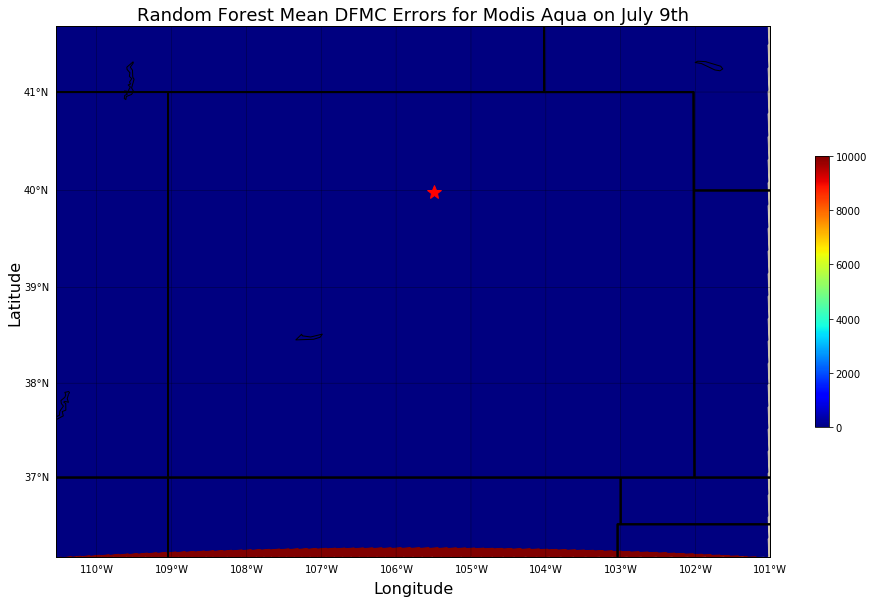

In [116]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pylab

%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 10)

TL = storeA[['b1','b2','b3','b4','b5','b6','b7','elevation','slope_cat','land_use_cat','LST','lat','lon','Errors','Predictions']]


#TL = pd.DataFrame(data=test_featuresT,columns=['b1','b2','b3','b4','b5','b6','b7','elevation','slope_cat','land_use_cat',
#                           'LST','soil_layer_0','soil_layer_1','soil_layer_2','soil_layer_3', 'lat','lon',
#                                         'Predictions', 'Errors'])

j = TL.groupby(['lat', 'lon']).mean().reset_index()
lat = np.array(j['lat'])
lon = np.array(j['lon'])
m = Basemap(projection='merc',llcrnrlat=36.15,urcrnrlat=41.66,llcrnrlon=-110.54,urcrnrlon=-101.00, resolution = 'i')
m.drawcoastlines()
m.drawcountries()
#m.etopo()
m.shadedrelief(scale=2.0)
m.drawstates(color='black',linewidth=2.0)
# draw parallels and meridians.
parallels = np.arange(-90.,91.,1.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5)
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,1.)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.5)
m.drawmapboundary(fill_color='white')
plt.xlabel('Longitude',fontsize=16, labelpad=24)
plt.ylabel('Latitude',fontsize=16, labelpad=34)
plt.title("Random Forest Mean DFMC Errors for Modis Aqua on July 9th",fontsize=18)
# Define a colormap
jet = plt.cm.get_cmap('jet')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
# Use below initially...then set vmin and cmax if comparing tables and want the same range
sc = plt.scatter(x,y, c=j['Errors'], vmin=np.min(j['Errors']), vmax =np.max(j['Errors']), cmap=jet, s=10, edgecolors='none')
#sc = plt.scatter(x,y, c=j['Errors'], vmin=0, vmax=8, cmap=jet, s=100, edgecolors='none')# And let's include that colorbar
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
#cbar.set_label(j['fuelMoisture'])
x1,y1 = m([-105.4894],[39.98443])
sc = plt.plot(x1,y1,"*",markersize=15, color="red")
plt.show()

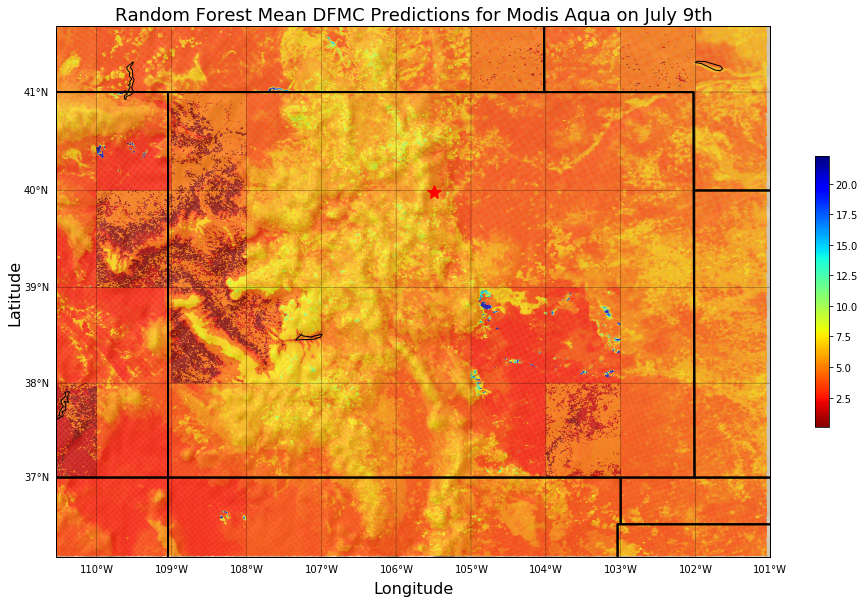

In [117]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pylab

%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 10)

TL = storeA[['b1','b2','b3','b4','b5','b6','b7','elevation','slope_cat','land_use_cat','LST','lat','lon','Errors','Predictions']]


#TL = pd.DataFrame(data=test_featuresT,columns=['b1','b2','b3','b4','b5','b6','b7','elevation','slope_cat','land_use_cat',
#                           'LST','soil_layer_0','soil_layer_1','soil_layer_2','soil_layer_3', 'lat','lon',
#                                         'Predictions', 'Errors'])

j = TL.groupby(['lat', 'lon']).mean().reset_index()
lat = np.array(j['lat'])
lon = np.array(j['lon'])
m = Basemap(projection='merc',llcrnrlat=36.15,urcrnrlat=41.66,llcrnrlon=-110.54,urcrnrlon=-101.00, resolution = 'i')
m.drawcoastlines()
m.drawcountries()
#m.etopo()
m.shadedrelief(scale=2.0)
m.drawstates(color='black',linewidth=2.0)
# draw parallels and meridians.
parallels = np.arange(-90.,91.,1.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5)
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,1.)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.5)
m.drawmapboundary(fill_color='white')
plt.xlabel('Longitude',fontsize=16, labelpad=24)
plt.ylabel('Latitude',fontsize=16, labelpad=34)
plt.title("Random Forest Mean DFMC Predictions for Modis Aqua on July 9th",fontsize=18)
# Define a colormap
jet = plt.cm.get_cmap('jet_r')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
# Use below initially...then set vmin and cmax if comparing tables and want the same range
sc = plt.scatter(x,y, c=j['Predictions'], vmin=np.min(j['Predictions']), vmax =np.max(j['Predictions']), cmap=jet, s=1, edgecolors='none')
#sc = plt.scatter(x,y, c=j['Predictions'], vmin=0, vmax=8, cmap=jet, s=100, edgecolors='none')# And let's include that colorbar
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
#cbar.set_label(j['fuelMoisture'])
x1,y1 = m([-105.4894],[39.98443])
sc = plt.plot(x1,y1,"*",markersize=15, color="red")
plt.show()

In [43]:
nc4 = netCDF4.Dataset('/Volumes/d1/mccandle/NASA-AIST/Data/geo_em.d01-rec-CO_backup.nc')
#DFMC = nc4.createVariable('DFMC', np.float32, ('south_north','west_east'))

print(nc4.dimensions.keys())

odict_keys(['south_north', 'west_east'])


In [55]:
xlat = nc4.variables['XLAT_M'][:][:]
#print(xlat[1:10])
#print(lat[1:10])
t = np.shape(xlat)
print(np.shape(xlat))
print(t[0])

(683, 872)
683


In [50]:
test4 = nc4.variables['XLAT_M'][:][:]
#print(xlat[1:10])
#print(lat[1:10])
t = print(np.shape(xlat))
print(np.shape(lat))

storeA['FMC'] = storeA['DFMC']
x = 0
i = 0
j = 0
# loop over south_north dimension:
for i in range(0,683):
    # loop over west_east dimension:
    for j in range(0,872):
        if lat[x] == xlat[i][i] & lon[j] == xlon[i][j]:
            storeA['FMC'][x] = storeA['Predictions']
        else:
            storeA['FMC'][x] = 0.08
            
                
        
        




[[-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 ...
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]]
[36.16002655 36.16004944 36.1600647  36.1600647  36.1600647  36.16009903
 36.16013336 36.16014481 36.16016388]
(683, 872)
(423023,)


In [31]:
print(modisnc.dimensions.keys())
print(modisnc.variables)
#DFMC = modisnc.createVariable('DFMC', np.float32, ('lat','lon'))

odict_keys(['south_north', 'west_east'])
OrderedDict([('HGT_M', <class 'netCDF4._netCDF4.Variable'>
float32 HGT_M(south_north, west_east)
    FieldType: 104
    MemoryOrder: XY 
    units: meters MSL
    description: GMTED2010 30-arc-second topography height
    stagger: M
    sr_x: 1
    sr_y: 1
unlimited dimensions: 
current shape = (683, 872)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('LANDMASK', <class 'netCDF4._netCDF4.Variable'>
float32 LANDMASK(south_north, west_east)
    FieldType: 104
    MemoryOrder: XY 
    units: none
    description: Landmask : 1=land, 0=water
    stagger: M
    sr_x: 1
    sr_y: 1
unlimited dimensions: 
current shape = (683, 872)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('LU_INDEX', <class 'netCDF4._netCDF4.Variable'>
float32 LU_INDEX(south_north, west_east)
    FieldType: 104
    MemoryOrder: XY 
    units: category
    description: Dominant category
    stagger: M
    sr_x: 1
    sr_y: 1
unlimited dimensions:

In [28]:
dim = modisnc.dimensions['south_north']
print(dim.values)

AttributeError: 'netCDF4._netCDF4.Dimension' object has no attribute 'values'

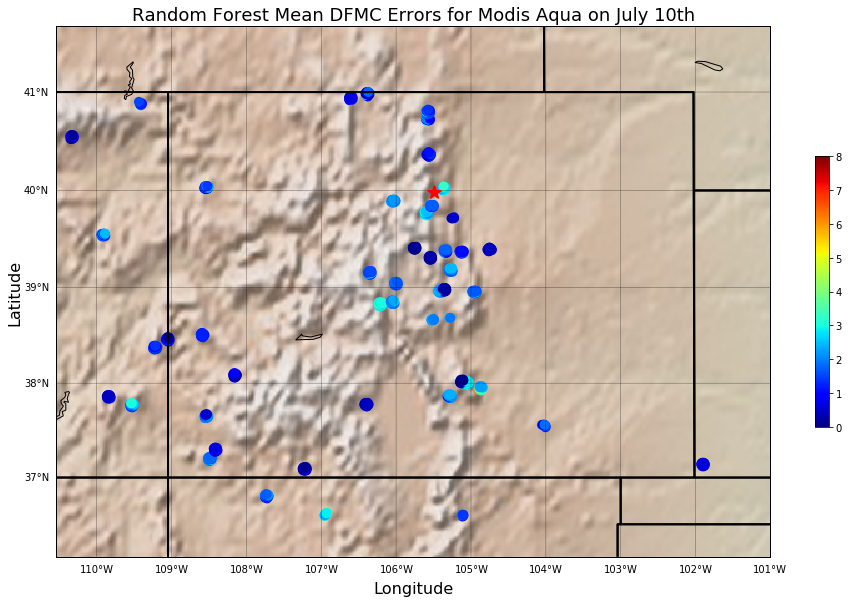

In [68]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pylab

%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 10)

TL = test_setA10[['b1','b2','b3','b4','b5','b6','b7','elevation','slope_cat',
                           'land_use_cat','lat','lon','LST','soil_layer_0','soil_layer_1',
                           'soil_layer_2','soil_layer_3','Predictions', 'Errors']]


#TL = pd.DataFrame(data=test_featuresT,columns=['b1','b2','b3','b4','b5','b6','b7','elevation','slope_cat','land_use_cat',
#                           'LST','soil_layer_0','soil_layer_1','soil_layer_2','soil_layer_3', 'lat','lon',
#                                         'Predictions', 'Errors'])

j = TL.groupby(['lat', 'lon']).mean().reset_index()
lat = np.array(j['lat'])
lon = np.array(j['lon'])
m = Basemap(projection='merc',llcrnrlat=36.15,urcrnrlat=41.66,llcrnrlon=-110.54,urcrnrlon=-101.00, resolution = 'i')
m.drawcoastlines()
m.drawcountries()
#m.etopo()
m.shadedrelief(scale=2.0)
m.drawstates(color='black',linewidth=2.0)
# draw parallels and meridians.
parallels = np.arange(-90.,91.,1.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5)
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,1.)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.5)
m.drawmapboundary(fill_color='white')
plt.xlabel('Longitude',fontsize=16, labelpad=24)
plt.ylabel('Latitude',fontsize=16, labelpad=34)
plt.title("Random Forest Mean DFMC Errors for Modis Aqua on July 10th",fontsize=18)
# Define a colormap
jet = plt.cm.get_cmap('jet')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
# Use below initially...then set vmin and cmax if comparing tables and want the same range
#sc = plt.scatter(x,y, c=j['Errors'], vmin=np.min(j['Errors']), vmax =np.max(j['Errors']), cmap=jet, s=100, edgecolors='none')
sc = plt.scatter(x,y, c=j['Errors'], vmin=0, vmax=8, cmap=jet, s=100, edgecolors='none')# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
#cbar.set_label(j['fuelMoisture'])
x1,y1 = m([-105.4894],[39.98443])
sc = plt.plot(x1,y1,"*",markersize=15, color="red")
plt.show()

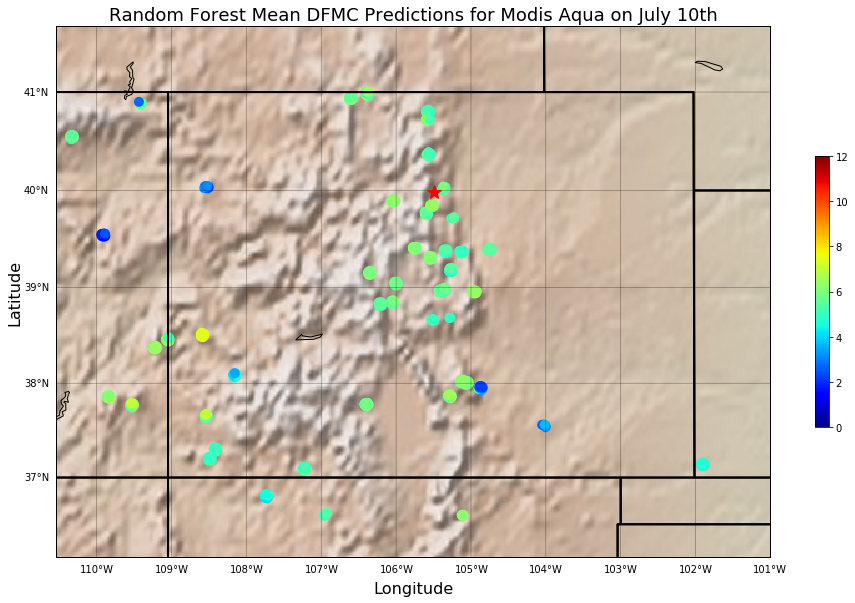

In [70]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pylab

%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 10)

TL = test_setA10[['b1','b2','b3','b4','b5','b6','b7','elevation','slope_cat',
                           'land_use_cat','lat','lon','LST','soil_layer_0','soil_layer_1',
                           'soil_layer_2','soil_layer_3','Predictions', 'Errors']]


#TL = pd.DataFrame(data=test_featuresT,columns=['b1','b2','b3','b4','b5','b6','b7','elevation','slope_cat','land_use_cat',
#                           'LST','soil_layer_0','soil_layer_1','soil_layer_2','soil_layer_3', 'lat','lon',
#                                         'Predictions', 'Errors'])

j = TL.groupby(['lat', 'lon']).mean().reset_index()
lat = np.array(j['lat'])
lon = np.array(j['lon'])
m = Basemap(projection='merc',llcrnrlat=36.15,urcrnrlat=41.66,llcrnrlon=-110.54,urcrnrlon=-101.00, resolution = 'i')
m.drawcoastlines()
m.drawcountries()
#m.etopo()
m.shadedrelief(scale=2.0)
m.drawstates(color='black',linewidth=2.0)
# draw parallels and meridians.
parallels = np.arange(-90.,91.,1.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5)
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,1.)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.5)
m.drawmapboundary(fill_color='white')
plt.xlabel('Longitude',fontsize=16, labelpad=24)
plt.ylabel('Latitude',fontsize=16, labelpad=34)
plt.title("Random Forest Mean DFMC Predictions for Modis Aqua on July 10th",fontsize=18)
# Define a colormap
jet = plt.cm.get_cmap('jet')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
# Use below initially...then set vmin and cmax if comparing tables and want the same range
#sc = plt.scatter(x,y, c=j['Predictions'], vmin=np.min(j['Predictions']), vmax =np.max(j['Predictions']), cmap=jet, s=100, edgecolors='none')
sc = plt.scatter(x,y, c=j['Predictions'], vmin=0, vmax=12, cmap=jet, s=100, edgecolors='none')
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
#cbar.set_label(j['fuelMoisture'])
x1,y1 = m([-105.4894],[39.98443])
sc = plt.plot(x1,y1,"*",markersize=15, color="red")
plt.show()

In [ ]:
from netCDF4 import Dataset
import numpy as np

# From Pedro, this will need to be in the netCDF file
#    real (kind = SP), parameter :: DX = 1.0, DY = 1.0
#    real (kind = SP), parameter :: XLONC = -97.5
#    real (kind = SP), parameter :: TRUELAT1 = 38.5, TRUELAT2 = 38.5
#    NAME OF THE PROJECTION, LAMBERT, MERCATOR, POLAR STEREOGRAPHIC???
#    character (len = :), parameter :: HDATE ='2000-01-24_12:00:00'
#    character (len = :), parameter :: FIELD = 'FMC' DECIDE NAMES DEAD AND LIVE FUEL MOISTURE

nCDF = Dataset('exampleOutput.nc', 'w', format='NETCDF4')
nCDF.description = 'Example Output File'

# dimensions
nCDF.createDimension('time', None)
nCDF.createDimension('lat', 72)
nCDF.createDimension('lon', 144)

# variables
times = nCDF.createVariable('time', 'f8', ('time',))
latitudes = nCDF.createVariable('latitude', 'f4', ('lat',))
longitudes = nCDF.createVariable('longitude', 'f4', ('lon',))
temp = nCDF.createVariable('temp', 'f4', ('time', 'lat', 'lon',))

# data
lats =  np.arange(-90, 90, 2.5)
lons =  np.arange(-180, 180, 2.5)
latitudes[:] = lats
longitudes[:] = lons
for i in range(5):
    temp[i,:,:] = np.random.uniform(size=(len(lats), len(lons)))

# group
# my_grp = root_grp.createGroup('my_group')

root_grp.close()

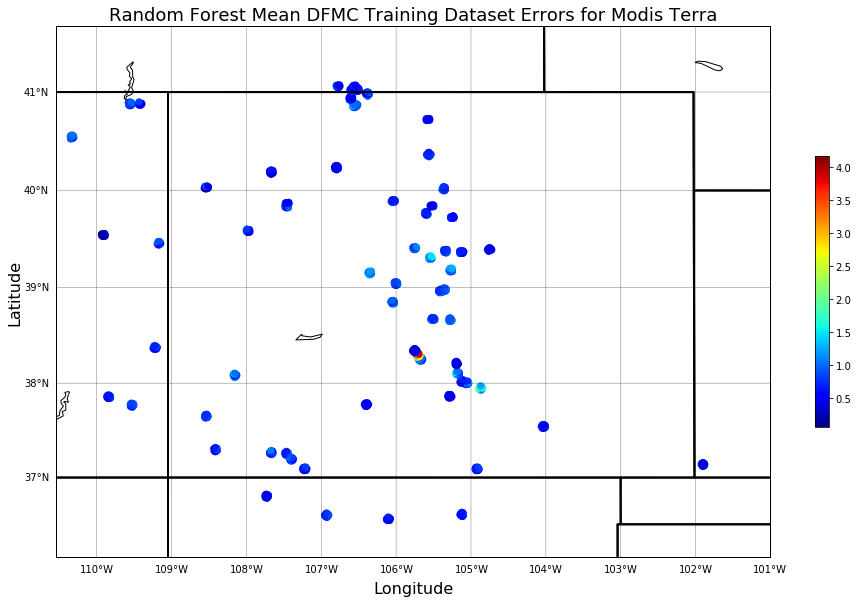

In [56]:
import matplotlib as mpl
import matplotlib.pyplot as plt

#Hack to fix missing PROJ4 env var
#import os
#import conda

#conda_file_dir = conda.__file__
#conda_dir = conda_file_dir.split('lib')[0]
#proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
#os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

import numpy as np
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 10)

TL = train_set[['b1','b2','b3','b4','b5','b6','b7','elevation','slope_cat',
                           'land_use_cat','lat','lon','LST','soil_layer_0','soil_layer_1',
                           'soil_layer_2','soil_layer_3','Predictions', 'Errors']]


#TL = pd.DataFrame(data=test_featuresT,columns=['b1','b2','b3','b4','b5','b6','b7','elevation','slope_cat','land_use_cat',
#                           'LST','soil_layer_0','soil_layer_1','soil_layer_2','soil_layer_3', 'lat','lon',
#                                         'Predictions', 'Errors'])

j = TL.groupby(['lat', 'lon']).mean().reset_index()
lat = np.array(j['lat'])
lon = np.array(j['lon'])
m = Basemap(projection='merc',llcrnrlat=36.15,urcrnrlat=41.66,llcrnrlon=-110.54,urcrnrlon=-101.00, resolution = 'i')
m.drawcoastlines()
m.drawcountries()
#m.etopo()
#m.shadedrelief(scale=2.0)
m.drawstates(color='black',linewidth=2.0)
# draw parallels and meridians.
parallels = np.arange(-90.,91.,1.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5)
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,1.)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.5)
m.drawmapboundary(fill_color='white')
plt.xlabel('Longitude',fontsize=16, labelpad=24)
plt.ylabel('Latitude',fontsize=16, labelpad=34)
plt.title("Random Forest Mean DFMC Training Dataset Errors for Modis Terra",fontsize=18)
# Define a colormap
jet = plt.cm.get_cmap('jet')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
sc = plt.scatter(x,y, c=j['Errors'], vmin=np.min(j['Errors']), vmax =np.max(j['Errors']), cmap=jet, s=50, edgecolors='none')
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
#cbar.set_label(j['fuelMoisture'])
plt.show()

In [ ]:
TL = pd.DataFrame(data=test_featuresTL,columns=['lat', 'lon', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7','elevation','slope_cat','land_use_cat', 'Predictions', 'Errors'])
j = TL.groupby(['lat', 'lon']).mean().reset_index()
lat = np.array(j['lat'])
lon = np.array(j['lon'])
m = Basemap(projection='merc',llcrnrlat=36.15,urcrnrlat=41.66,llcrnrlon=-110.54,urcrnrlon=-101.00, resolution = 'i')
m.drawcoastlines()
m.drawcountries()
m.shadedrelief(scale=2.0)
m.drawstates(color='black',linewidth=2.0)
# draw parallels and meridians.
parallels = np.arange(-90.,91.,1.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5)
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,1.)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.5)
m.drawmapboundary(fill_color='white')
plt.xlabel('Longitude',fontsize=16, labelpad=24)
plt.ylabel('Latitude',fontsize=16, labelpad=34)
plt.title("Random Forest Mean DFMC Prediction for Modis Terra",fontsize=18)
# Define a colormap
jet = plt.cm.get_cmap('jet')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
sc = plt.scatter(x,y, c=j['Predictions'], vmin=np.min(j['Predictions']), vmax =np.max(j['Predictions']), cmap=jet, s=35, edgecolors='none')
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
#cbar.set_label(j['fuelMoisture'])
plt.show()

In [ ]:
AL = pd.DataFrame(data=test_featuresAL,columns=['lat', 'lon', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
                                                'b7','elevation','slope_cat','land_use_cat', 'Predictions', 'Errors'])
j = AL.groupby(['lat', 'lon']).mean().reset_index()
lat = np.array(j['lat'])
lon = np.array(j['lon'])
m = Basemap(projection='merc',llcrnrlat=36.15,urcrnrlat=41.66,llcrnrlon=-110.54,urcrnrlon=-101.00, resolution = 'i')
m.drawcoastlines()
m.drawcountries()
m.shadedrelief(scale=2.0)
m.drawstates(color='black',linewidth=2.0)
# draw parallels and meridians.
parallels = np.arange(-90.,91.,1.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5)
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,1.)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.5)
m.drawmapboundary(fill_color='white')
plt.xlabel('Longitude',fontsize=16, labelpad=24)
plt.ylabel('Latitude',fontsize=16, labelpad=34)
plt.title("Random Forest Mean DFMC Errors for Modis Aqua",fontsize=18)
# Define a colormap
jet = plt.cm.get_cmap('jet')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
sc = plt.scatter(x,y, c=j['Errors'], vmin=np.min(j['Errors']), vmax =np.max(j['Errors']), cmap=jet, s=50, edgecolors='none')
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
#cbar.set_label(j['fuelMoisture'])
plt.show()

In [ ]:
AL = pd.DataFrame(data=test_featuresAL,columns=['lat', 'lon', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
                                                'b7','elevation','slope_cat','land_use_cat', 'Predictions', 'Errors'])
j = AL.groupby(['lat', 'lon']).mean().reset_index()
lat = np.array(j['lat'])
lon = np.array(j['lon'])
m = Basemap(projection='merc',llcrnrlat=36.15,urcrnrlat=41.66,llcrnrlon=-110.54,urcrnrlon=-101.00, resolution = 'i')
m.drawcoastlines()
m.drawcountries()
m.shadedrelief(scale=2.0)
m.drawstates(color='black',linewidth=2.0)
# draw parallels and meridians.
parallels = np.arange(-90.,91.,1.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5)
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,1.)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.5)
m.drawmapboundary(fill_color='white')
plt.xlabel('Longitude',fontsize=16, labelpad=24)
plt.ylabel('Latitude',fontsize=16, labelpad=34)
plt.title("Random Forest Mean DFMC Errors for Modis Aqua",fontsize=18)
# Define a colormap
jet = plt.cm.get_cmap('jet')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
sc = plt.scatter(x,y, c=j['Errors'], vmin=np.min(j['Errors']), vmax =np.max(j['Errors']), cmap=jet, s=50, edgecolors='none')
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
#cbar.set_label(j['fuelMoisture'])
plt.show()

In [13]:
# Test multiple linear regression
lmA = LinearRegression()
lmT = LinearRegression()
lmA.fit(train_featuresA,train_labelsA)
lmT.fit(train_featuresT,train_labelsT)
print("The coefficients for training on Aqua dataset are the following: ", lmA.coef_)
print("The coefficients for training on Terra dataset are the following: ", lmT.coef_)
pred_lmA = lmA.predict(test_featuresA)
pred_lmT = lmT.predict(test_featuresT)
errors_lmA = abs(pred_lmA - test_labelsA)
errors_lmT = abs(pred_lmT - test_labelsT)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for Aqua:', round(np.mean(errors_lmA),2))
print('Mean Absolute Error for Terra:',round(np.mean(errors_lmT),2))

The coefficients for training on Aqua dataset are the following:  [-0.0007849   0.00129488 -0.00158337  0.00017475  0.10456132 -0.00029041
 -0.00013387]
The coefficients for training on Terra dataset are the following:  [ 3.20845805e-03 -4.69176510e-04 -3.87178790e-03  1.02560430e-03
 -5.31355095e-01 -3.84945041e-04  2.08202302e-03]
Mean Absolute Error for Aqua: 2.34
Mean Absolute Error for Terra: 2.62


The ANN Configuration for Aqua:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 40        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________
The ANN Configuration for Terra:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 30        
_______________

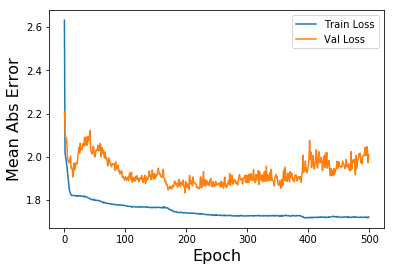

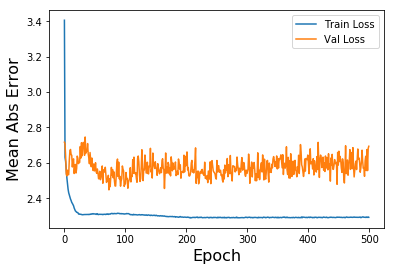

In [14]:
# Build Artificial Neural Networks
# First, normalize training data
meanA = train_featuresA.mean(axis=0)
meanT = train_featuresT.mean(axis=0)
stdA = train_featuresA.std(axis=0)
stdT = train_featuresT.std(axis=0)
trainA = (train_featuresA - meanA) / stdA
trainT = (train_featuresT - meanT) / stdT
testA = (test_featuresA - meanA) / stdA
testT = (test_featuresT - meanT) / stdT


def build_model(train_data):
    model = keras.Sequential([
        keras.layers.Dense(5, activation=tf.nn.relu,
                          input_shape=(train_data.shape[1],)),
        keras.layers.Dense(5, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
    
    optimizer = tf.train.RMSPropOptimizer(0.001)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae'])
    return model

EPOCHS_A = 500
EPOCHS_T = 500
modelA = build_model(train_featuresA)
modelT = build_model(train_featuresT)
print("The ANN Configuration for Aqua:")
modelA.summary()
print("The ANN Configuration for Terra:")
modelT.summary()

# Train model and store training stats
historyA = modelA.fit(trainA, train_labelsA, epochs=EPOCHS_A,
                      validation_split=0.2,verbose=0)
historyT = modelT.fit(trainT, train_labelsT, epochs=EPOCHS_T,
                      validation_split=0.2,verbose=0)

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch',fontsize=16)
    plt.ylabel('Mean Abs Error',fontsize=16)
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
            label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
            label='Val Loss')
    plt.legend()
    #plt.ylim([0,5])
    
plot_history(historyA)
plot_history(historyT)

[lossA, maeA] = modelA.evaluate(testA,test_labelsA,verbose=0)
print("Mean Absolute Error for Aqua: ", maeA)
[lossT, maeT] = modelT.evaluate(testT,test_labelsT,verbose=0)
print("Mean Absolute Error for Terra: ", maeT)

In [15]:
# Let's try gradient boosted regression
# Fit Regression Model
paramsA = {'n_estimators':2000, 'max_depth': 12, 'min_samples_split':100, 'learning_rate': 0.03, 'loss':'ls'}
paramsT = {'n_estimators':2000, 'max_depth': 12, 'min_samples_split':100, 'learning_rate': 0.03, 'loss':'ls'}
clfA = ensemble.GradientBoostingRegressor(**paramsA)
clfT = ensemble.GradientBoostingRegressor(**paramsT)
clfA.fit(train_featuresA,train_labelsA)
clfT.fit(train_featuresT,train_labelsT)
pred_clfA = clfA.predict(test_featuresA)
pred_clfT = clfT.predict(test_featuresT)
errors_clfA = abs(pred_clfA - test_labelsA)
errors_clfT = abs(pred_clfT - test_labelsT)
# Print out the MAE
print('Mean Absolute Error for Aqua:',round(np.mean(errors_clfA),2))
print('Mean Absolute Error for Terra:',round(np.mean(errors_clfT),2))

Mean Absolute Error for Aqua: 2.4
Mean Absolute Error for Terra: 2.76


In [15]:
ANNpredictionsA = modelA.predict(testA)
ANNpredictionsT = modelT.predict(testT)

In [86]:
# Test using an ensemble of techniques
predTestA = (np.array(pred_clfA) + np.array(predictionsA) + np.array(ANNpredictionsA)) / 3
errorTestA = abs(predTestA - test_labelsA)
print('Mean Absolute Error for Aqua using ML Ensemble Mean:',round(np.mean(errorTestA),2))
predTestA = (np.array(pred_clfA) + np.array(predictionsA)) / 2
errorTestA = abs(predTestA - test_labelsA)
print('Mean Absolute Error for Aqua using ML Ensemble Mean:',round(np.mean(errorTestA),2))

# Test using an ensemble of techniques
predTestT = (np.array(pred_clfT) + np.array(predictionsT) + np.array(ANNpredictionsT)) / 3
errorTestT = abs(predTestT - test_labelsT)
print('Mean Absolute Error for Terra using ML Ensemble Mean:',round(np.mean(errorTestT),2))
# Test using an ensemble of techniques
predTestT = (np.array(pred_clfT) + np.array(predictionsT)) / 2
errorTestT = abs(predTestT - test_labelsT)
print('Mean Absolute Error for Terra using ML Ensemble Mean:',round(np.mean(errorTestT),2))

Mean Absolute Error for Aqua using ML Ensemble Mean: 1.53
Mean Absolute Error for Aqua using ML Ensemble Mean: 1.39
Mean Absolute Error for Terra using ML Ensemble Mean: 2.11
Mean Absolute Error for Terra using ML Ensemble Mean: 1.94


(array([ 2801.,   141.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,  1539.,  1285.,   466.,  1122.,
          934.,  2871.,  1858.,   835.,  1557.,  1751.,  2919.,  2396.,
         3439.,  4934.,  6078.,  4445.,  6122.,  8148.,  6847.,  5280.,
         7270.,  5123.,  3803.,  2200.,  3338.,  3059.,  2156.,  1776.,
         1697.,  1180.,   964.,   558.,  1186.,   511.,   355.,   512.,
          396.,   597.]),
 array([ 1037.3371582 ,  1085.50412598,  1133.67109375,  1181.83806152,
         1230.0050293 ,  1278.17199707,  1326.33896484,  1374.50593262,
         1422.67290039,  1470.83986816,  1519.00683594,  1567.17380371,
         1615.34077148,  1663.50773926,  1711.67470703,  1759.8416748 ,
         1808.00864258,  1856.17561035,  1904.34257812,  1952.5095459 ,
         2000.67651367,  2048.84348145,  2097.01044922,  2145.17741699,
         2193.34438477,  2241.51135254,  2289.67832031,  2337.84528809,
         2386.01225586,  2434.17922363

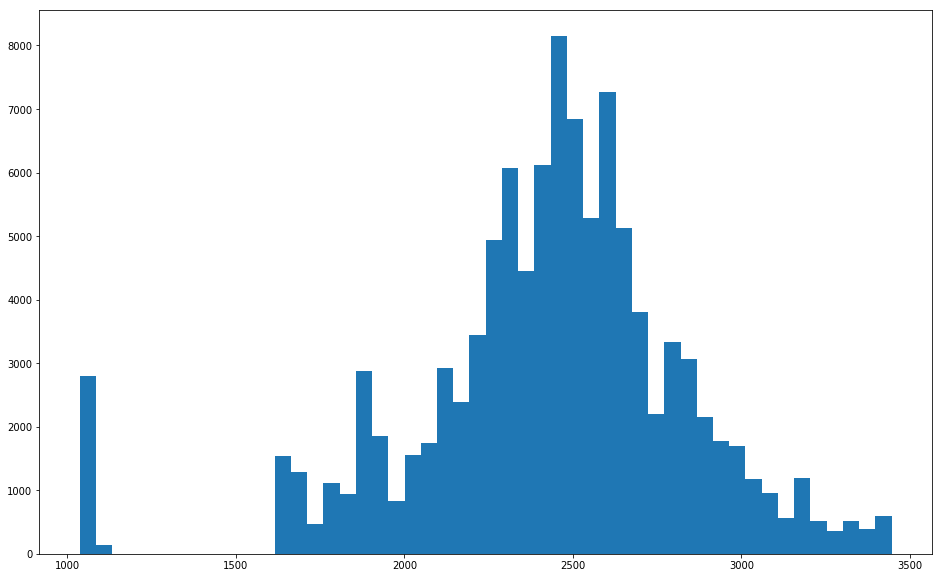

In [87]:
plt.hist(storeA['elevation'],bins=50)

(array([ 2664.,   129.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,  1844.,  1526.,   367.,   946.,
         1014.,  3126.,  2038.,   935.,  1741.,  2039.,  3650.,  2869.,
         4117.,  5977.,  7383.,  5293.,  7094.,  9603.,  8216.,  6467.,
         8825.,  6255.,  4531.,  2655.,  3869.,  3619.,  2548.,  2069.,
         1981.,  1368.,  1131.,   658.,  1457.,   622.,   436.,   595.,
          464.,   732.]),
 array([ 1037.3371582 ,  1085.50412598,  1133.67109375,  1181.83806152,
         1230.0050293 ,  1278.17199707,  1326.33896484,  1374.50593262,
         1422.67290039,  1470.83986816,  1519.00683594,  1567.17380371,
         1615.34077148,  1663.50773926,  1711.67470703,  1759.8416748 ,
         1808.00864258,  1856.17561035,  1904.34257812,  1952.5095459 ,
         2000.67651367,  2048.84348145,  2097.01044922,  2145.17741699,
         2193.34438477,  2241.51135254,  2289.67832031,  2337.84528809,
         2386.01225586,  2434.17922363

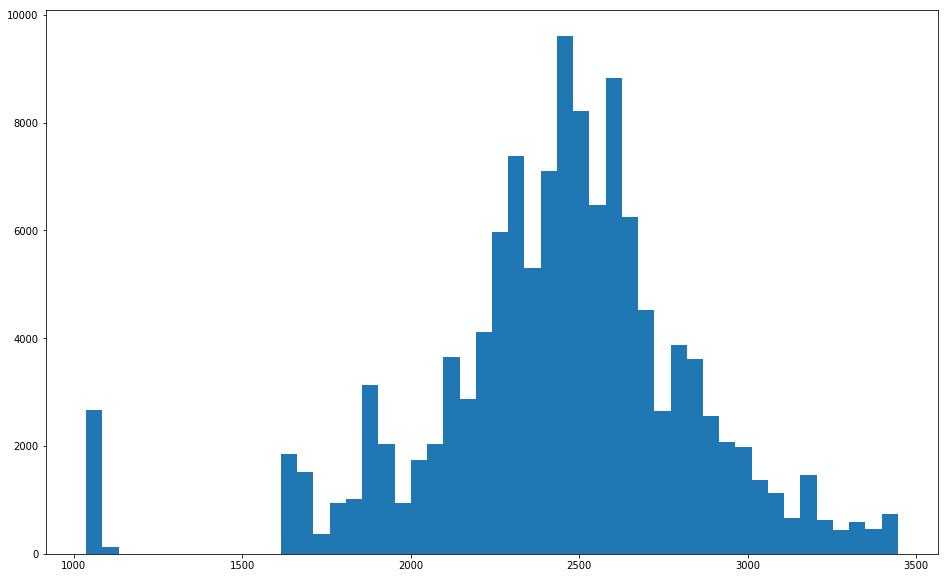

In [88]:
plt.hist(storeT['elevation'],bins=50)